
#**Import Library**


In [ ]:
#keep the glove file in the
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Extraction**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/440project/trainingData.csv')
data.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


# **Task A**

# **Data Visulization**

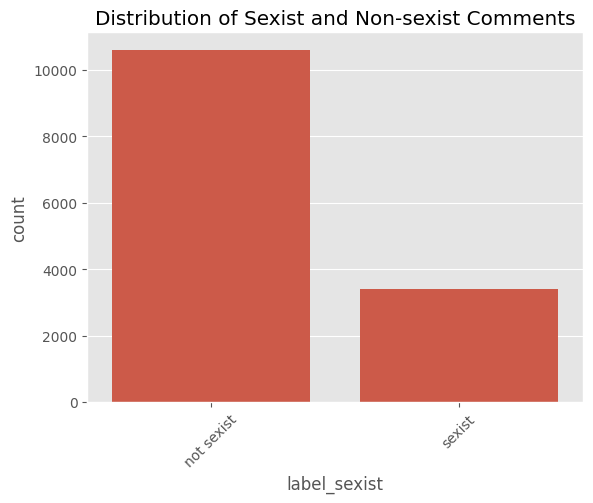

In [ ]:
task1 = data[['text', 'label_sexist', 'label_category']]
task1.head()

sns.countplot(x=task1['label_sexist'],data=task1)
plt.title('Distribution of Sexist and Non-sexist Comments')
plt.xticks(rotation=45)
plt.show()

#**Data Preprocessing**

In [ ]:
def preprocess_text(text):
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    TAG_RE = re.compile(r'<[^>]+>')
    text = TAG_RE.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    text_lower = text.lower()
    text_no_punct = text_lower.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text



In [ ]:
text = task1['text']
x = text.apply(preprocess_text)
task1['preprocess_text'] = x
task1.head()

<ipython-input-93-acb6947aff3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task1['preprocess_text'] = x


,text,label_sexist,label_category,preprocess_text
0,"Damn, this writing was pretty chaotic",not sexist,none,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,yeah apparently bunch misogynistic virgins one...
2,How the FUCK is this woman still an MP!!!???,not sexist,none,fuck woman still mp
3,Understand. Know you're right. At same time I ...,not sexist,none,understand know right time know enough money w...
4,Surprized they didn't stop and rape some women,not sexist,none,surprized stop rape women


In [ ]:
text = task1['preprocess_text']
task1['label_sexist'] = task1['label_sexist'].map({'not sexist': 0, 'sexist': 1})
labels = task1['label_sexist']
task1.head()

<ipython-input-94-584735372014>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task1['label_sexist'] = task1['label_sexist'].map({'not sexist': 0, 'sexist': 1})


,text,label_sexist,label_category,preprocess_text
0,"Damn, this writing was pretty chaotic",0,none,damn writing pretty chaotic
1,"Yeah, and apparently a bunch of misogynistic v...",0,none,yeah apparently bunch misogynistic virgins one...
2,How the FUCK is this woman still an MP!!!???,0,none,fuck woman still mp
3,Understand. Know you're right. At same time I ...,0,none,understand know right time know enough money w...
4,Surprized they didn't stop and rape some women,0,none,surprized stop rape women


# **Tokenization**

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
data_padded = pad_sequences(sequences, maxlen=256)


# **Vectorization**

In [ ]:
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = '/content/drive/MyDrive/440project/glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
vocab_size = len(word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8537434991659307

# **Data Spliting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11200, 256) (2800, 256) (11200,) (2800,)


# **Plot Function**

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# **Bidirectional LSTM**

In [ ]:
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model1.add(Bidirectional(LSTM(16)))
model1.add(Dropout(0.4))
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(4, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(1, activation='sigmoid'))


model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 256, 100)          2038200   
                                                                 
 bidirectional_9 (Bidirecti  (None, 32)                14976     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 264       
                                                                 
 dropout_19 (Dropout)        (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                      

Epoch 1/20
448/448 [==============================] - 27s 51ms/step - loss: 0.6102 - accuracy: 0.7348 - precision_6: 0.2125 - recall_6: 0.0379 - val_loss: 0.5593 - val_accuracy: 0.7486 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/20
448/448 [==============================] - 10s 22ms/step - loss: 0.5477 - accuracy: 0.7591 - precision_6: 0.4444 - recall_6: 0.0059 - val_loss: 0.4934 - val_accuracy: 0.7486 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/20
448/448 [==============================] - 11s 25ms/step - loss: 0.4796 - accuracy: 0.7971 - precision_6: 0.7281 - recall_6: 0.2494 - val_loss: 0.4208 - val_accuracy: 0.8229 - val_precision_6: 0.8270 - val_recall_6: 0.3736
Epoch 4/20
448/448 [==============================] - 11s 25ms/step - loss: 0.4183 - accuracy: 0.8308 - precision_6: 0.7905 - recall_6: 0.4035 - val_loss: 0.4043 - val_accuracy: 0.8336 - val_precision_6: 0.8051 - val_recall_6: 0.4460
Epoch 5/20
448/448 [============================

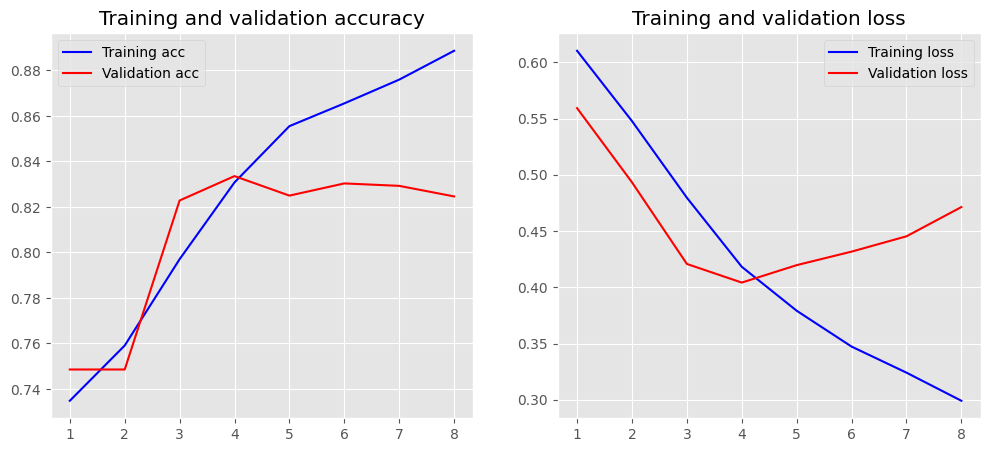

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history3 = model1.fit(X_train, y_train,
                      epochs=20,
                      batch_size=25,
                      validation_data=(X_test, y_test),callbacks=[early_stopping])



loss, accuracy, precision, recall = model1.evaluate(X_train, y_train, verbose=False)
print("LSTM Model Train Accuracy: {:.4f}".format(accuracy))
print("LSTM Model Train Precision: {:.4f}".format(precision))
print("LSTM Model Train Recall: {:.4f}".format(recall))
loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=False)

print("LSTM Model Test Accuracy {:.4f}".format(accuracy))
print("LSTM Model Test Precision: {:.4f}".format(precision))
print("LSTM Model Test Recall: {:.4f}".format(recall))

plot_history(history3)



88/88 [==============================] - 2s 12ms/step


Text(50.722222222222214, 0.5, 'Gold')

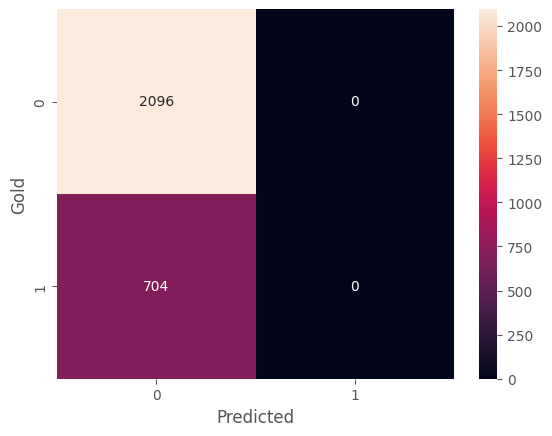

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Gold')

# **Task B**

# **Data Visulization**

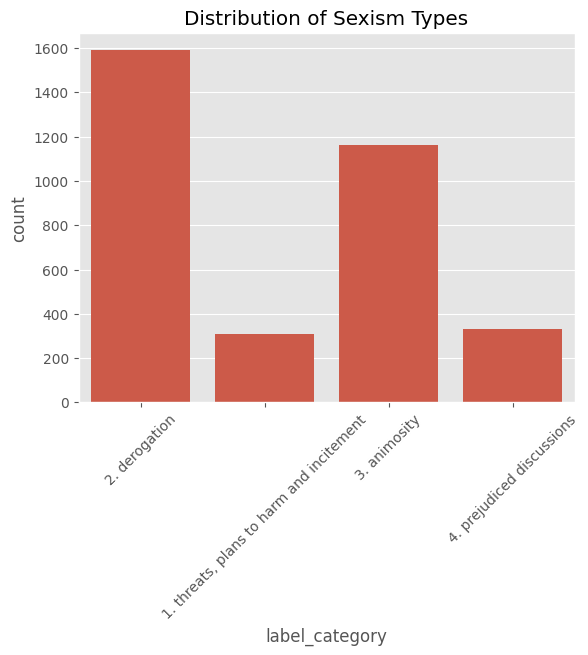

In [ ]:
data = task1[task1['label_sexist'] != 0]
task2 = data[['text','label_category','preprocess_text']]
task2.head()

sns.countplot(x=task2['label_category'],data=task1)
plt.title('Distribution of Sexism Types')
plt.xticks(rotation=45)
plt.show()

#**Data Preprocessing**

In [ ]:
task2['label_category'] = task2['label_category'].map({'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3 })

labels = task2['label_category']
labels = pd.get_dummies(data['label_category']).values

task2.head()

<ipython-input-106-a0bfdecfa722>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task2['label_category'] = task2['label_category'].map({'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3 })


,text,label_category,preprocess_text
8,"just the inside of your wallet: cash, bank car...",1,inside wallet cash bank cards credit cards deb...
11,They get the initial chance because they are a...,1,get initial chance attractive women flock see ...
17,ugly chicks A pussy is a pussy.,1,ugly chicks pussy pussy
18,fuck her off with a nine mm this is what you g...,0,fuck nine mm get arab fucks monkey
19,How about I talk shit to an idiot like you? Ar...,2,talk shit idiot like nazi like bitch


In [ ]:
text2 = task2['preprocess_text']

# **Tokenization**

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(text2)

sequences = tokenizer.texts_to_sequences(text2)
word_index = tokenizer.word_index
data_padded = pad_sequences(sequences, maxlen=256)


# **Vectorization**

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#**Data Spliting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)

# **Bidirectional LSTM**

In [ ]:
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model1.add(Bidirectional(LSTM(128, return_sequences=True)))
model1.add(Dropout(0.4))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dropout(0.4))
model1.add(Dense(8, activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(4, activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

model1.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 100)          884000    
                                                                 
 bidirectional_12 (Bidirect  (None, 256, 256)          234496    
 ional)                                                          
                                                                 
 dropout_24 (Dropout)        (None, 256, 256)          0         
                                                                 
 bidirectional_13 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 8)                

Epoch 1/20
85/85 [==============================] - 5s 63ms/step - loss: 0.8896 - accuracy: 0.6015 - precision_7: 0.6992 - recall_7: 0.4242 - val_loss: 1.0517 - val_accuracy: 0.5176 - val_precision_7: 0.5361 - val_recall_7: 0.4044
Epoch 2/20
85/85 [==============================] - 4s 48ms/step - loss: 0.8111 - accuracy: 0.6461 - precision_7: 0.7326 - recall_7: 0.5099 - val_loss: 1.0828 - val_accuracy: 0.5206 - val_precision_7: 0.5595 - val_recall_7: 0.4353
Epoch 3/20
85/85 [==============================] - 4s 51ms/step - loss: 0.7257 - accuracy: 0.7016 - precision_7: 0.7737 - recall_7: 0.5887 - val_loss: 1.1375 - val_accuracy: 0.5029 - val_precision_7: 0.5307 - val_recall_7: 0.4324
Epoch 4/20
85/85 [==============================] - 3s 41ms/step - loss: 0.6646 - accuracy: 0.7333 - precision_7: 0.7941 - recall_7: 0.6442 - val_loss: 1.2772 - val_accuracy: 0.5059 - val_precision_7: 0.5279 - val_recall_7: 0.4868
Epoch 5/20
85/85 [==============================] - 3s 40ms/step - loss: 0.5

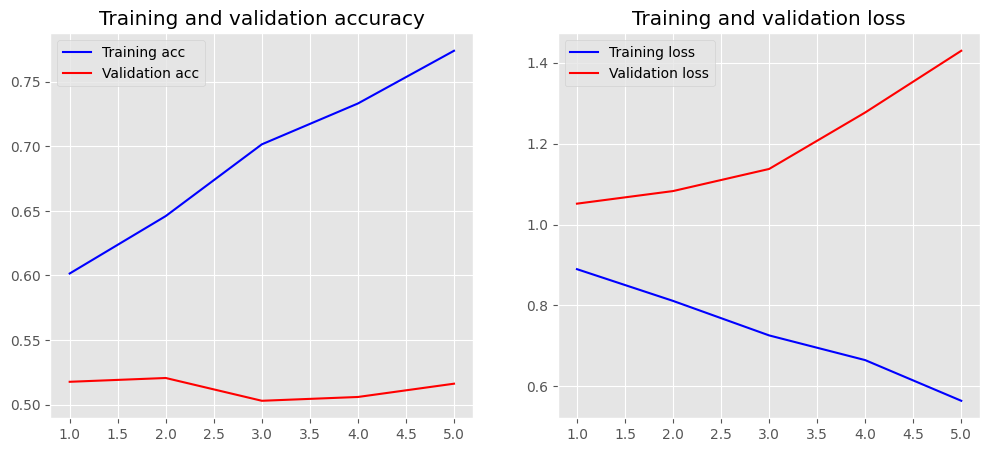

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history3 =model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])


loss, accuracy, precision, recall = model1.evaluate(X_train, y_train, verbose=False)

print("LSTM Model Train Accuracy: {:.4f}".format(accuracy))
print("LSTM Model Train Precision: {:.4f}".format(precision))
print("LSTM Model Train Recall: {:.4f}".format(recall))

loss, accuracy, precision, recall = model1.evaluate(X_test, y_test, verbose=False)

print("LSTM Model Test Accuracy {:.4f}".format(accuracy))
print("LSTM Model Test Precision: {:.4f}".format(precision))
print("LSTM Model Test Recall: {:.4f}".format(recall))


plot_history(history3)